In this notebook, we determine the short-circuit lengths and impedances in order to match low-power measurements, using the full-wave T-resonator model as a basis. The short-circuit are added to this model, with given length and resistance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import skrf as rf
from skrf.media import Coaxial
rf.stylely()

In [2]:
from scipy.optimize import minimize

# Low power measurements

In [3]:
filename = 'data/RES2.ASC'

In [4]:
exp_freq,reS11,imS11 = np.loadtxt(filename, skiprows=14, delimiter=';', unpack=True)

In [5]:
exp_mag = np.sqrt(reS11**2 + imS11**2)
exp_mag_dB = 20*np.log10(exp_mag)
# find the match frequency 
exp_frequency = rf.frequency.f_2_frequency(exp_freq) # -> into a skrf Frequency 
exp_freq_match = exp_freq[np.argmin(exp_mag)]
print('Match frequency : {} MHz'.format(exp_freq_match/1e6))

Match frequency : 62.640625 MHz


Text(0.5, 0, 'f [MHz]')

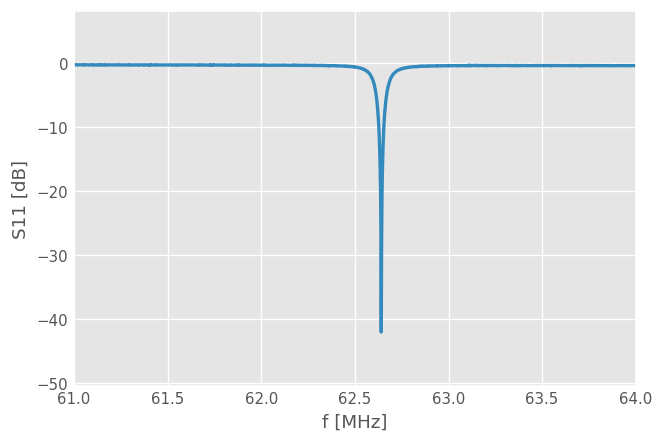

In [6]:
fig,ax = plt.subplots()
ax.plot(exp_freq/1e6, exp_mag_dB, lw=2)
ax.grid(True)
ax.set_ylabel('S11 [dB]')
ax.set_xlabel('f [MHz]')

# Electromagnetic Model

Here we import the full-wave model from its S-parameters and we connect two short-circuit of given length and resistance.

In [7]:
# Importing T-resonator S-parameters from HFSS 
resonator_base = rf.Network('data/SSA50_resonator_RFModels_Resonator_Base_alpha1.0_50Ohm.s4p', f_unit='MHz')
# The experimental frequency band does not match the HFSS simulated one.  
# So before making any operations between Networks, need to interpolate them. 
# It also speedup very much the Network connecting calculations.
resonator_base = resonator_base.interpolate_from_f(exp_frequency)

In [8]:
resonator_base

4-Port Network: 'SSA50_resonator_RFModels_Resonator_Base_alpha1.0_50Ohm',  61000000.0-64000000.0 Hz, 1601 pts, z0=[50.+0.j 50.+0.j 50.+0.j 50.+0.j]

In [10]:
# Coaxial media associated to transmission line for service stub and short circuits
sc_DUT_media = Coaxial(frequency=resonator_base.frequency, Dint=127.92e-3, Dout=216e-3, epsilon_r=1)
sc_CEA_media = Coaxial(frequency=resonator_base.frequency, Dint=140e-3, Dout=219e-3, epsilon_r=1)
service_stub_media = Coaxial(frequency=resonator_base.frequency, Dint=55.5e-3, Dout=152e-3, epsilon_r=1)

In [11]:
# Creating networks for service stubs and shorts
def resonator_network(d_sc_CEA = 161e-3, Z_sc_CEA = 10e-3, 
                      d_sc_DUT = 38e-3, Z_sc_DUT = 10e-3, 
                      d_sstub = 50e-3):
    '''
    Create and return the resonator Network from specified short-circuit lengths and resistances
    '''
    # Creating transmission line medias 
    service_stub = service_stub_media.line(d_sstub, unit='m') ** service_stub_media.short()
    sc_CEA = sc_CEA_media.line(d_sc_CEA, unit='m')**sc_CEA_media.resistor(Z_sc_CEA)**sc_CEA_media.short()
    sc_DUT = sc_DUT_media.line(d_sc_DUT, unit='m')**sc_DUT_media.resistor(Z_sc_DUT)**sc_DUT_media.short()
    # Connecting the resonator with its ports. 
    # Port 1 : resonator input
    # Port 2 : DUT
    # Port 3 : CEA
    # Port 4: service stub
    _res = rf.connect(resonator_base, 3, service_stub, 0) # resonator to service stub 
    _res = rf.connect(_res, 2, sc_CEA, 0) # resonator to CEA
    res = rf.connect(_res, 1, sc_DUT, 0) # resonator to DUT 

    return res

In [12]:
def f_match(resonator_network):
    'Return the resonator match frequency'
    return resonator_network.frequency[resonator_network.s_mag.argmin()].f[0]

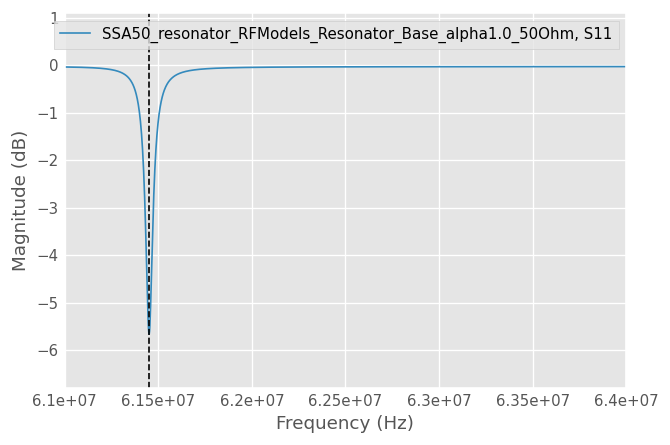

In [13]:
# Plot the default values resonator Network
res=resonator_network()
res.plot_s_db()
plt.axvline(f_match(res), ls='--', color='k' )

# Optimized Parameters (length and impedance)

Now that we now the optimized short lengths in order to get the match frequency, let's optimize the short impedance in order to fit the resonator experimental Q quality factor.   

In [14]:
def optim_fun_impedance(short_properties):
    'Generates a resonator network from short impedance (Z_DUT,Z_CEA) and returns t'
    
    d_DUT, Z_DUT, d_CEA, Z_CEA, d_sstub = short_properties
    # calculates the resonator Network
    res = resonator_network(d_sc_CEA=d_CEA, d_sc_DUT=d_DUT, 
                            Z_sc_CEA=Z_CEA, Z_sc_DUT=Z_DUT,
                           d_sstub=d_sstub)

    crit = np.sum( (res.s_db.squeeze() - exp_mag_dB)**2) #least square 
    print(short_properties, crit)
    return crit    

In [15]:
d_DUT_0 = 0.035 # m  
d_CEA_0 = 0.035 # m
Z_DUT_0 = 0.003 # Ohm
Z_CEA_0 = 0.006 # Ohm
d_sstub_0 = 0

bounds_pties = ((10e-3, 70-3), (1e-4, 1), # d,Z DUT
                (5e-3, 200e-3), (1e-4, 1), # d,Z CEA
                (0, 700e-3)) # service stub

In [16]:
opt_res = minimize(optim_fun_impedance, (d_DUT_0, Z_DUT_0, d_CEA_0, Z_CEA_0, d_sstub_0),
                  bounds=bounds_pties)

[0.035 0.003 0.035 0.006 0.   ] 6864.24029777134
[0.03500001 0.003      0.035      0.006      0.        ] 6864.239055704805
[0.035      0.00300001 0.035      0.006      0.        ] 6864.240309742257
[0.035      0.003      0.03500001 0.006      0.        ] 6864.240040980361
[0.035      0.003      0.035      0.00600001 0.        ] 6864.240360852489
[3.5e-02 3.0e-03 3.5e-02 6.0e-03 1.0e-08] 6864.240303381606
[6.7e+01 1.0e-04 2.0e-01 1.0e-04 0.0e+00] 6948.85386552589
[6.7e+01 1.0e-04 2.0e-01 1.0e-04 0.0e+00] 6948.853720256366
[6.7000e+01 1.0001e-04 2.0000e-01 1.0000e-04 0.0000e+00] 6948.853751369424
[6.7000000e+01 1.0000000e-04 1.9999999e-01 1.0000000e-04 0.0000000e+00] 6948.853812985662
[6.7000e+01 1.0000e-04 2.0000e-01 1.0001e-04 0.0000e+00] 6948.853805519358
[6.7e+01 1.0e-04 2.0e-01 1.0e-04 1.0e-08] 6948.853865537821
[2.36977018e+01 1.97525819e-03 9.33042754e-02 3.91518046e-03
 0.00000000e+00] 7185.805962627204
[2.36977018e+01 1.97525819e-03 9.33042754e-02 3.91518046e-03
 0.00000000e+00

[3.81853981e-02 3.16269687e-02 5.01810384e-02 1.74964081e-02
 2.90281084e-06] 4547.48047883368
[3.81853981e-02 3.16269687e-02 5.01810384e-02 1.74963981e-02
 2.91281084e-06] 4547.480431611825
[0.0361299  0.03179388 0.05664395 0.01750492 0.        ] 4311.198898330851
[0.03612991 0.03179388 0.05664395 0.01750492 0.        ] 4311.200254677885
[0.0361299  0.03179389 0.05664395 0.01750492 0.        ] 4311.1990767745465
[0.0361299  0.03179388 0.05664396 0.01750492 0.        ] 4311.198964179893
[0.0361299  0.03179388 0.05664395 0.01750493 0.        ] 4311.198966338593
[3.61299046e-02 3.17938763e-02 5.66439487e-02 1.75049215e-02
 1.00000000e-08] 4311.198896413867
[0.03393568 0.03059636 0.06264016 0.01692815 0.        ] 4000.964767479441
[0.03393569 0.03059636 0.06264016 0.01692815 0.        ] 4000.9660789218465
[0.03393568 0.03059637 0.06264016 0.01692815 0.        ] 4000.9649672295027
[0.03393568 0.03059636 0.06264017 0.01692815 0.        ] 4000.9647295285768
[0.03393568 0.03059636 0.06264016 

[0.02506058 0.02563982 0.08735934 0.01452703 0.        ] 1890.4308512738226
[2.50605774e-02 2.56398182e-02 8.73593449e-02 1.45270164e-02
 1.00000000e-08] 1890.4306919208634
[1.e-02 1.e-04 2.e-01 1.e-04 0.e+00] 8885.639355054109
[1.000001e-02 1.000000e-04 2.000000e-01 1.000000e-04 0.000000e+00] 8885.640758664698
[1.0000e-02 1.0001e-04 2.0000e-01 1.0000e-04 0.0000e+00] 8885.641025336321
[1.0000000e-02 1.0000000e-04 1.9999999e-01 1.0000000e-04 0.0000000e+00] 8885.640032624622
[1.0000e-02 1.0000e-04 2.0000e-01 1.0001e-04 0.0000e+00] 8885.640199835614
[1.e-02 1.e-04 2.e-01 1.e-04 1.e-08] 8885.639350088979
[0.02504754 0.0256177  0.08745688 0.01451452 0.        ] 1899.0041002890605
[0.02504755 0.0256177  0.08745688 0.01451452 0.        ] 1899.0174404284692
[0.02504754 0.02561771 0.08745688 0.01451452 0.        ] 1899.0045345089177
[0.02504754 0.0256177  0.08745689 0.01451452 0.        ] 1899.0077789750512
[0.02504754 0.0256177  0.08745688 0.01451453 0.        ] 1899.0042573419332
[2.50475365e

In [26]:
d_DUT_opt, Z_DUT_opt, d_CEA_opt, Z_CEA_opt, d_sstub_opt = opt_res.x
print(f'Optimization results: d_DUT_opt={d_DUT_opt:.3}, Z_DUT_opt={Z_DUT_opt:.3},', 
      f'd_CEA_opt={d_CEA_opt:.3}, Z_CEA_opt={Z_CEA_opt:.3}, d_sstub_opt={d_sstub_opt:.3}')

Optimization results: d_DUT_opt=0.025, Z_DUT_opt=0.0256, d_CEA_opt=0.0876, Z_CEA_opt=0.0145, d_sstub_opt=0.0


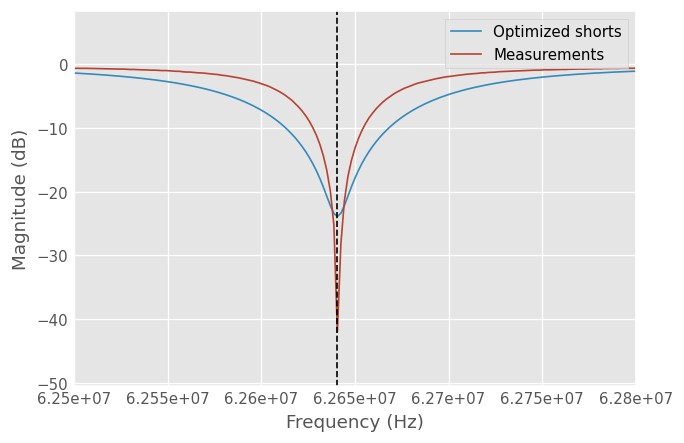

In [18]:
resonator_network(d_sc_DUT=d_DUT_opt, d_sc_CEA=d_CEA_opt, 
                  Z_sc_CEA=Z_CEA_opt, Z_sc_DUT=Z_DUT_opt, 
                  d_sstub=d_sstub_opt).plot_s_db()
plt.plot(exp_freq, exp_mag_dB)
plt.xlim(62.5e6, 62.8e6)
plt.axvline(exp_freq_match, color='k', ls='--')
plt.legend(('Optimized shorts', 'Measurements'))

Clearly, while the resonance peak location is correct, one can see the shape of S11 differs from measurements. A reason could be material losses, not properly modeled in the full-wave simulation.

## Map of the short lengths

Here we are making a 2D chart (L_CEA, L_DUT) vs |S11|

In [19]:
# Reduce the network to a single frequency
idx_f_match = np.argmin(abs(res.frequency.f - 62.64e6))

res_f_match = res[idx_f_match]

In [20]:
# Creating networks for service stubs and shorts
def resonator_network_fmatch(f_match=62.64e6, 
                      d_sc_CEA = 161e-3, Z_sc_CEA = 10e-3, 
                      d_sc_DUT = 38e-3, Z_sc_DUT = 10e-3, 
                      d_sstub = 50e-3):
    '''
    Create and return the resonator Network from specified short-circuit lengths and resistances
    '''
    # take the closest frequency to the desired one
    idx_f_match = np.argmin(abs(resonator_base.frequency.f - f_match))
    freq_obj = resonator_base.frequency[idx_f_match]
    
    # Coaxial media associated to transmission line for service stub and short circuits
    _sc_DUT_media = Coaxial(frequency=freq_obj, Dint=127.92e-3, Dout=216e-3, epsilon_r=1)
    _sc_CEA_media = Coaxial(frequency=freq_obj, Dint=140e-3, Dout=219e-3, epsilon_r=1)
    _service_stub_media = Coaxial(frequency=freq_obj, Dint=55.5e-3, Dout=152e-3, epsilon_r=1)

    # Creating transmission line medias 
    service_stub = _service_stub_media.line(d_sstub, unit='m') ** _service_stub_media.short()
    sc_CEA = _sc_CEA_media.line(d_sc_CEA, unit='m')**_sc_CEA_media.resistor(Z_sc_CEA)**_sc_CEA_media.short()
    sc_DUT = _sc_DUT_media.line(d_sc_DUT, unit='m')**_sc_DUT_media.resistor(Z_sc_DUT)**_sc_DUT_media.short()
    # Connecting the resonator with its ports. 
    # Port 1 : resonator input
    # Port 2 : DUT
    # Port 3 : CEA
    # Port 4: service stub
    _res = rf.connect(resonator_base[idx_f_match], 3, service_stub, 0) # resonator to service stub 
    _res = rf.connect(_res, 2, sc_CEA, 0) # resonator to CEA
    res = rf.connect(_res, 1, sc_DUT, 0) # resonator to DUT
    return res

In [21]:
d_DUTs = np.linspace(10e-3, 35e-3, 100)
d_CEAs = np.linspace(10e-3, 140e-3, 100)

dd_DUT, dd_CEA = np.meshgrid(d_DUTs, d_CEAs)

In [22]:
def S11_f_match(d_DUT, d_CEA):
    _res = resonator_network_fmatch(d_sc_DUT=d_DUT, Z_sc_DUT=Z_DUT_opt,
                                    d_sc_CEA=d_CEA, Z_sc_CEA=Z_CEA_opt,
                                    d_sstub=d_sstub_opt)    
    return np.squeeze(_res.s_db[0])

vfunc = np.vectorize(S11_f_match)

In [23]:
S11 = vfunc(dd_DUT, dd_CEA)

C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


Text(0, 0.5, 'L CEA [mm]')

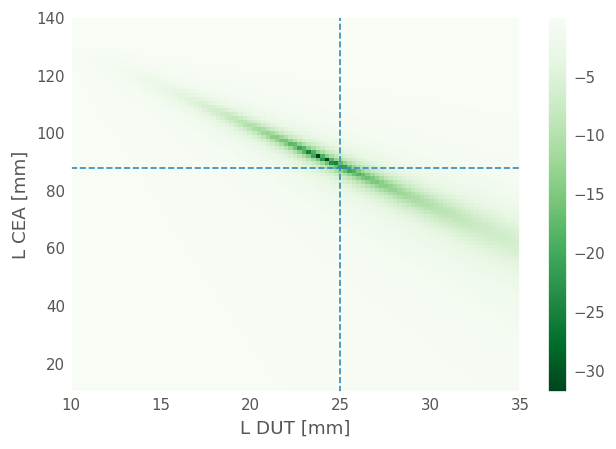

In [24]:
fig,ax=plt.subplots()
c=ax.pcolor(dd_DUT*1e3, dd_CEA*1e3, S11, cmap='Greens_r')
fig.colorbar(c)
ax.axvline(d_DUT_opt*1e3, ls='--')
ax.axhline(d_CEA_opt*1e3, ls='--')

ax.set_xlabel('L DUT [mm]')
ax.set_ylabel('L CEA [mm]')